<center>
<h1> Rossmann Store Sales Prediction: 
</center>

#### Packages :

In [1]:
#Importing required packages
import pandas as pd 
import numpy as np 
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble,linear_model,neighbors,metrics,tree
import xgboost
import pickle

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

#### Data : 

In [2]:
#Importing data:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

C:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#printing samples in train data
train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [4]:
#printing samples in test data
test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [5]:
#printing samples in store data
store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


#### Data Preparation :

In [6]:
#In Train data Id variable and Test data Customers variable not exist.
test.drop(['Id'],axis=1,inplace=True)

#Number of customers is one of the signifgicant variable for Predicting sales
# Creating Customers variable in test data using train data
AVG_Cust = train.groupby(['Store'],as_index=False)['Customers'].mean().astype(int)
test = test.merge(AVG_Cust,on='Store',how='left')

#Adding Target variable in Testing data
test['Sales'] = 900

In [7]:
train.drop(['Customers'],axis=1,inplace=True)
train = train.merge(AVG_Cust,on='Store',how='left')
train = train[['Store','DayOfWeek','Date','Open','Promo','StateHoliday','SchoolHoliday','Customers','Sales']]

In [8]:
#Creating new variable in train and test data sets.
train['Split'] = 1
test['Split'] = 2
#Combining both train and test data sets.
Data = pd.concat([train,test],axis=0)

In [9]:
#Checking dimension of the data
print("Dimension of the data : ",Data.shape)
print("Dimension of Store data : ",store.shape)

Dimension of the data :  (1058297, 10)
Dimension of Store data :  (1115, 10)


#### Missing Values :

In [10]:
# Missing Values :
print("Number of Missing values in Test data : ",Data.isnull().sum().sum())
print("Number of Missing values in Store data : ",store.isnull().sum().sum())

Number of Missing values in Test data :  11
Number of Missing values in Store data :  2343


In [11]:
#Checking null values in Test data
Data[Data.Open.isnull() ==True]

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Customers,Sales,Split
479,622,4,2015-09-17,NaN,1,0,0,357,900,2
1335,622,3,2015-09-16,NaN,1,0,0,357,900,2
2191,622,2,2015-09-15,NaN,1,0,0,357,900,2
3047,622,1,2015-09-14,NaN,1,0,0,357,900,2
4759,622,6,2015-09-12,NaN,0,0,0,357,900,2
5615,622,5,2015-09-11,NaN,0,0,0,357,900,2
6471,622,4,2015-09-10,NaN,0,0,0,357,900,2
7327,622,3,2015-09-09,NaN,0,0,0,357,900,2
8183,622,2,2015-09-08,NaN,0,0,0,357,900,2
9039,622,1,2015-09-07,NaN,0,0,0,357,900,2


In [12]:
#Imputing missing values in Test data.

# In Test data Open Variable has 11 missing values and all are from 622 store.
# We are replacing with '1' value because StateHoliday value is '0' 
# Case 1 : If StateHoliday '0' and Open value is '1' then we have Sales values.
# Case 2 : If StateHoliday '0' and Open value is '0' then Sale value is '0' 
#  Based on above conditions and Mode value we are replacing with '1' value. 
Data.Open.fillna(1,inplace=True)
Data.Open = Data.Open.astype(int)

In [13]:
#Checking Missing vaslues in Store data
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [14]:
#Imputing missing values with 'zero' value
store.CompetitionDistance.fillna(store.CompetitionDistance.max(),inplace=True)
store.fillna(0,inplace=True)
#Checking number of missing values after imputing
store.isnull().sum().sum()

0

In [15]:
#Merging data
DATA = Data.merge(store,on='Store',how='left')
DATA.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Customers,Sales,Split,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,1,1,0,1,467,5263,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,1,1,0,1,486,6064,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,1,1,0,1,620,8314,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,1,1,0,1,1100,13995,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,1,1,0,1,444,4822,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [16]:
#Changing Data type of Date Variable and Extracting month and Year from it.
DATA['Date'] = pd.to_datetime(DATA.Date,format="%Y-%m-%d")
DATA['Month']= DATA.Date.dt.month
DATA['Year'] = DATA.Date.dt.year
#Modifying existing varaibles.
DATA['CompetitionOpenSinceYear'] =  DATA.Year-DATA.CompetitionOpenSinceYear
DATA['CompetitionOpenSinceMonth'] = DATA.CompetitionOpenSinceYear*12 +(DATA.Month-DATA.CompetitionOpenSinceMonth)
DATA['Promo2SinceYear'] = np.where(DATA.Promo2SinceYear ==0,0,DATA.Year-DATA.Promo2SinceYear)
DATA['Month'] = DATA.Month.astype(str)
DATA['DayOfWeek']= DATA.DayOfWeek.astype(str)
DATA.drop(['Year','Date'],axis=1,inplace=True)


#Modifying StateHoliday variable.
DATA['StateHoliday']= np.where(DATA.StateHoliday=='a','a',np.where(DATA.StateHoliday=='b','b',np.where(DATA.StateHoliday=='c','c','0')))

In [17]:
#Seperating Numerical and categorical data type column names
num_col=[key for key in dict(DATA.dtypes) if dict(DATA.dtypes)[key] in ['int64','int32','float64','float32']]
cat_col=[key for key in dict(DATA.dtypes) if dict(DATA.dtypes)[key] in ['object']]

#Seperating Numerical and Categorical data
NUM_data = DATA[num_col]
Cat_data = DATA[cat_col]

In [18]:
DATA.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Customers,Sales,Split,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month
0,1,5,1,1,0,1,467,5263,1,c,a,1270.0,82.0,7.0,0,0.0,0.0,0,7
1,2,5,1,1,0,1,486,6064,1,a,a,570.0,92.0,8.0,1,13.0,5.0,"Jan,Apr,Jul,Oct",7
2,3,5,1,1,0,1,620,8314,1,a,a,14130.0,103.0,9.0,1,14.0,4.0,"Jan,Apr,Jul,Oct",7
3,4,5,1,1,0,1,1100,13995,1,c,c,620.0,70.0,6.0,0,0.0,0.0,0,7
4,5,5,1,1,0,1,444,4822,1,a,a,29910.0,3.0,0.0,0,0.0,0.0,0,7


#### Numerical Data :

In [19]:
#Printing sampels in Numerical data
NUM_data.head(3)

,Store,Open,Promo,SchoolHoliday,Customers,Sales,Split,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,1,1,1,467,5263,1,1270.0,82.0,7.0,0,0.0,0.0
1,2,1,1,1,486,6064,1,570.0,92.0,8.0,1,13.0,5.0
2,3,1,1,1,620,8314,1,14130.0,103.0,9.0,1,14.0,4.0


In [20]:
#Considering only Train data for understanding variable summary.
Num_data = NUM_data[NUM_data.Split==1]

In [21]:
#Numerical data Analysis :
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=Num_data[Num_data.columns.difference(['Store','Split'])].apply(lambda x: var_summary(x))

In [22]:
#Data Audit Report for Numerical data
#num_summary.to_excel("NUM_Summary.xlsx")
num_summary.astype(int)

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales,SchoolHoliday
N,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
NMISS,0,0,0,0,0,0,0,0,0,0,0
SUM,-2147483648,-2147483648,654736522,643529565,844392,388080,509178,11848110,1056875,-2147483648,181721
MEAN,5613,7724,643,632,0,0,0,11,1,5773,0
MEDIAN,2330,91,8,563,1,0,1,1,0,5744,0
STD,8498,11227,935,321,0,0,0,15,1,3849,0
VAR,72221753,126061974,874905,103186,0,0,0,234,2,14821931,0
MIN,20,-31,-2,199,0,0,0,0,-2,0,0
P1,50,-21,-2,274,0,0,0,0,-1,0,0
P5,130,-7,-1,341,0,0,0,0,0,0,0


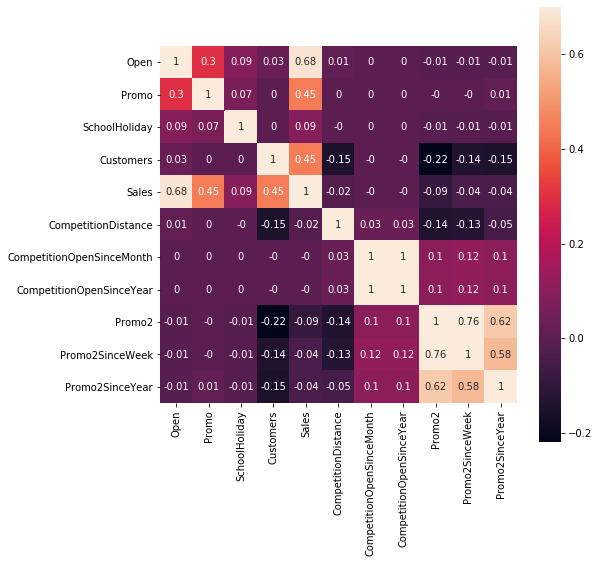

In [24]:
#Checking Correlation 
corr = np.round(Num_data[['Open', 'Promo', 'SchoolHoliday', 'Customers','Sales', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear']].corr(),2)
plt.figure(figsize=(8,8))
sns.heatmap(data=corr, vmax=.7, square=True,annot=True)
plt.show()

In [25]:
#From above correlation plot we obeserve that 
#==> DayOfWeek,Open,Promo and Customers variables are Positively correlated with Sales variable. 
#==> DaysOfWeek variable have negative correlation with target variable.
#==> Four variables have some relation with Target variable remaining all variables having fless correlation.

#### Categorical Data :

In [26]:
#Printing Categorical data
Cat_data.head(3)

,DayOfWeek,StateHoliday,StoreType,Assortment,PromoInterval,Month
0,5,0,c,a,0,7
1,5,0,a,a,"Jan,Apr,Jul,Oct",7
2,5,0,a,a,"Jan,Apr,Jul,Oct",7


In [27]:
#Modifying PromoInterval Variable
Cat_data['PromoInterval'] = np.where(Cat_data.PromoInterval=='Jan,Apr,Jul,Oct','1',np.where(Cat_data.PromoInterval=='Feb,May,Aug,Nov','2',np.where(Cat_data.PromoInterval=='Mar,Jun,Sept,Dec','3','0')))

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


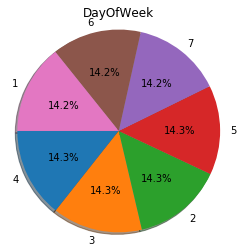

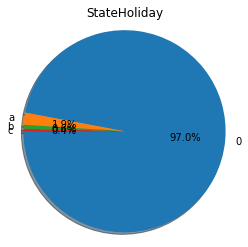

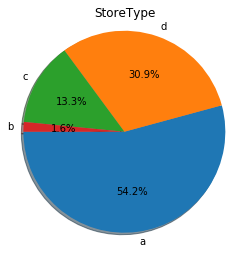

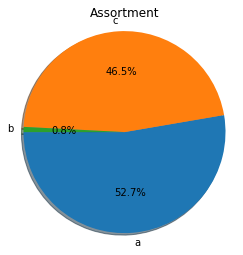

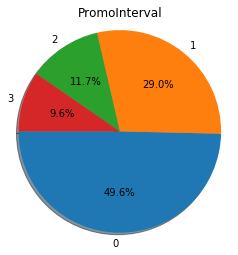

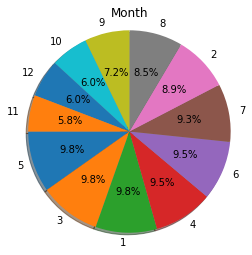

In [28]:
#Checking Distribution of values for each category 
for i in Cat_data.columns:
    labels = list(Cat_data[str(i)].value_counts().index)
    sizes = Cat_data[str(i)].value_counts()
    plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=180)
    plt.axis('equal')
    plt.title(str(i))
    plt.plot()
    fig=plt.gcf()
    fig.set_size_inches(4,4)
    plt.show()

In [29]:
#Assortment is Ordinal Categorical variable.
#Assortment - describes an assortment level: a = basic, b = extra, c = extended
Cat_data['Assortment']= np.where(Cat_data.Assortment=='a',1,np.where(Cat_data.Assortment=='b',2,3))

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
#Creating Dummy Variables for Nominal Categorical Variable.
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

#Creating dummy variable for categorical variables
for c_feature in Cat_data.columns.difference(['Assortment']):
    Cat_data[c_feature] = Cat_data[c_feature].astype('category')
    Cat_data = create_dummies(Cat_data , c_feature )

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [31]:
#Printing Categorical data after creating Dummy variables.
Cat_data.head()

,Assortment,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,PromoInterval_1,PromoInterval_2,PromoInterval_3,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### Train and Test Split :

In [32]:
#Combining Both Numerical and Categorical data
Data = pd.concat([NUM_data,Cat_data],axis=1)

#Seperating Train and Test data
TRAIN = Data[Data.Split==1]
TEST = Data[Data.Split==2]

In [33]:
#if Open value is '0' then Sales value is '0' for all samples in Training data.
len(TRAIN[(((TRAIN.Open ==0) & (TRAIN.Sales < 0))|((TRAIN.Open ==0) & (TRAIN.Sales > 0)))])

0

In [34]:
#Filtering data based on Open variable and Considering Open value is '1' because if Open value is zero then sale value is "zero"
TRAIN_1 = TRAIN[TRAIN.Open==1]
TEST_1 = TEST[TEST.Open==1]
TEST_0 = TEST[TEST.Open==0]

In [35]:
#Checking dimension of the data sets
print(TRAIN_1.shape)
print(TEST_1.shape)
print(TEST_0.shape)

(844392, 40)
(35104, 40)
(5984, 40)


<Figure size 360x360 with 0 Axes>

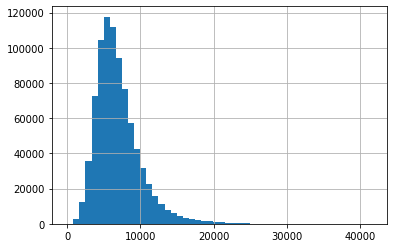

<Figure size 360x360 with 0 Axes>

In [36]:
#Checking Distribution of Target Variable
TRAIN_1.Sales.hist(bins=50)
plt.figure(figsize=(5,5))

In [37]:
#train and Test split 
train_x,test_x,train_y,test_y = train_test_split(TRAIN_1[TRAIN_1.columns.difference(['Sales','Split','Store','Open'])],TRAIN_1['Sales'],test_size=0.4,random_state=123)


#### Feature Selection :

In [46]:
#Performing RFE 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Feature extraction
model = LinearRegression()
rfe = RFE(model,20)
fit = rfe.fit(train_x,train_y)

#Creating Data Frame
Result = pd.DataFrame()
Result['Col_name'] = train_x.columns
Result['Support'] = fit.support_
Result['Rank'] = fit.ranking_
Result.to_excel("RFE.xlsx") 
Result.sort_values(['Rank'],ascending =True)    

,Col_name,Support,Rank
1,CompetitionDistance,False,17
4,Customers,False,16
19,Month_7,False,15
24,Promo2SinceWeek,False,14
26,PromoInterval_1,False,13
2,CompetitionOpenSinceMonth,False,12
3,CompetitionOpenSinceYear,False,11
14,Month_2,False,10
34,StoreType_c,False,9
11,Month_10,False,8


In [47]:
#Feature Selection using XGboost.
xg =xgboost.XGBRegressor(random_state=1234)
xg = xg.fit(train_x,train_y)
#Checking accuracy for train and test data
print("Train and Test Accuracy :")
print(xg.score(train_x,train_y))
print(xg.score(test_x,test_y))

C:\Users\Administrator\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:49:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train and Test Accuracy :
0.7270178023426042
0.7269812214279985


In [48]:
#Identifying Key variables and Printing top 20 variables.
feature_importances_XG = pd.DataFrame(xg.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
XG = pd.DataFrame(feature_importances_XG)
XG.to_excel('XG_Features.xlsx')
XG =XG.head(20)
lis_xg= XG.index
lis_xg

Index(['Customers', 'Promo', 'Promo2', 'Month_12', 'StoreType_b',
       'StoreType_d', 'DayOfWeek_4', 'Assortment', 'DayOfWeek_5',
       'Promo2SinceYear', 'DayOfWeek_3', 'CompetitionDistance',
       'Promo2SinceWeek', 'DayOfWeek_6', 'DayOfWeek_7', 'PromoInterval_1',
       'Month_8', 'DayOfWeek_2', 'Month_3', 'Month_10'],
      dtype='object')

In [49]:
#Feature Selection using Random Forest.
rf = ensemble.RandomForestRegressor(random_state=1234,max_depth=3)
rf = rf.fit(train_x,train_y)
#Checking accuracy for train and test data
print(rf.score(train_x,train_y))
print(rf.score(test_x,test_y))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5225566556643684
0.5235141679676492


In [50]:
#Identifying Key variables and Printing top 20 variables.
feature_importances_RF = pd.DataFrame(rf.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
RF = pd.DataFrame(feature_importances_RF)
RF.to_excel("RF_Features.xlsx")
RF = RF.head(20)
lis_rf= RF.index
lis_rf

Index(['Customers', 'Promo', 'StoreType_b', 'Assortment', 'PromoInterval_2',
       'Month_9', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval_1', 'PromoInterval_3', 'Month_7', 'SchoolHoliday',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_c',
       'Month_8', 'Month_6', 'CompetitionDistance'],
      dtype='object')

In [126]:
#Considering XGBoost Feature Technique
train_x = train_x[lis_xg]
test_x =test_x[lis_xg]
TEST_x = TEST_1[lis_xg]

## Model Building :

### Linear Regression :

In [52]:
#Linear Regression :
lr = linear_model.LinearRegression()
lr = lr.fit(train_x,train_y)

In [53]:
#Checking Accuracy for train and Test data
print(lr.score(train_x,train_y))
print(lr.score(test_x,test_y))

0.6494518055236769
0.6493298160791058


In [54]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,lr.predict(train_x)))
print(metrics.mean_squared_error(test_y, lr.predict(test_x)))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,lr.predict(train_x))))
print(np.sqrt(metrics.mean_squared_error(test_y,lr.predict(test_x))))

Mean Square Error :

3391245.0663935016
3359082.5580700263

Root Mean Square Error :

1841.533346533128
1832.7800080942684


<Figure size 288x288 with 0 Axes>

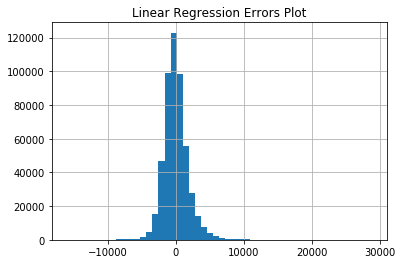

<Figure size 288x288 with 0 Axes>

In [55]:
#Checking Error Distribution :
(train_y-lr.predict(train_x)).hist(bins=50)
plt.title("Linear Regression Errors Plot")
plt.figure(figsize=(4,4))

### Lasso Regression :

In [56]:
#Lasso Regression :
ls = linear_model.Lasso()
ls = ls.fit(train_x,train_y)

In [57]:
#Checking Accuracy for train and Test data
print(ls.score(train_x,train_y))
print(ls.score(test_x,test_y))

0.6493886332959911
0.6493266468367964


In [58]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,ls.predict(train_x)))
print(metrics.mean_squared_error(test_y, ls.predict(test_x)))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,ls.predict(train_x))))
print(np.sqrt(metrics.mean_squared_error(test_y,ls.predict(test_x))))

Mean Square Error :

3391856.2020628573
3359112.916358389

Root Mean Square Error :

1841.6992702563732
1832.7882901083772


<Figure size 288x288 with 0 Axes>

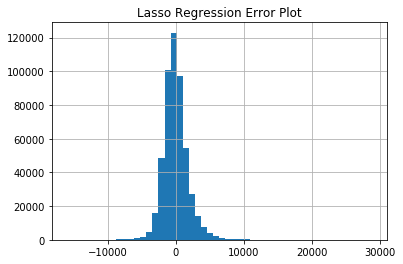

<Figure size 288x288 with 0 Axes>

In [59]:
#Checking Error Distribution :
(train_y-ls.predict(train_x)).hist(bins=50)
plt.title("Lasso Regression Error Plot")
plt.figure(figsize=(4,4))

### Ridge Regression :

In [60]:
#Lasso Regression :
rg = linear_model.Ridge()
rg = rg.fit(train_x,train_y)

In [61]:
#Checking Accuracy for train and Test data
print(rg.score(train_x,train_y))
print(rg.score(test_x,test_y))

0.6494518037855792
0.6493300100213898


In [62]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,rg.predict(train_x)))
print(metrics.mean_squared_error(test_y, rg.predict(test_x)))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,rg.predict(train_x))))
print(np.sqrt(metrics.mean_squared_error(test_y,rg.predict(test_x))))

Mean Square Error :

3391245.0832080664
3359080.700289772

Root Mean Square Error :

1841.5333510984988
1832.779501273891


<Figure size 288x288 with 0 Axes>

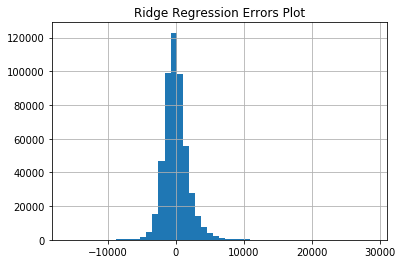

<Figure size 288x288 with 0 Axes>

In [63]:
#Checking Error Distribution :
(train_y-rg.predict(train_x)).hist(bins=50)
plt.title("Ridge Regression Errors Plot")
plt.figure(figsize=(4,4))

### Decision Trees :

In [68]:
#decision tree with tuning parameters.
param_dt = {'max_depth': [5,6,7,8,10],'max_features':[8,12,15,20]}
dt = GridSearchCV(estimator=tree.DecisionTreeRegressor(random_state=1234), param_grid=param_dt, cv=3,verbose=True, n_jobs=-1)
dt = dt.fit(train_x,train_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.1s finished


In [69]:
#Checking Accuracy for train and Test data
print(dt.score(train_x,train_y))
print(dt.score(test_x,test_y))

0.7522107087134069
0.746123426243385


In [72]:
#Predicting values for train and test data sets.
pred_dt_train = dt.predict(train_x)
pred_dt_test = dt.predict(test_x)

In [73]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_dt_train))
print(metrics.mean_squared_error(test_y, pred_dt_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_dt_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_dt_test)))

Mean Square Error :

2397143.1740965876
2431893.0148928794

Root Mean Square Error :

1548.2710273387497
1559.4527934159723


<Figure size 288x288 with 0 Axes>

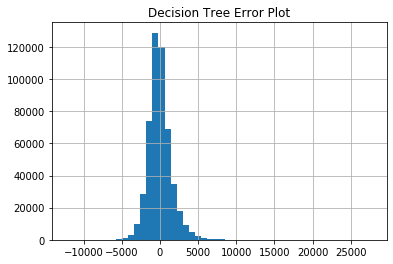

<Figure size 288x288 with 0 Axes>

In [74]:
#Checking Error Distribution :
(train_y-pred_dt_train).hist(bins=50)
plt.title("Decision Tree Error Plot")
plt.figure(figsize=(4,4))

In [78]:
#Saving model
import pickle
pickle.dump(dt,open('dt_model','wb'))

### Bagging :

In [75]:
#Bagging model with different tuning parameters
param_bg = {'n_estimators': [80,100,120,150,200]}
bg = GridSearchCV(estimator=ensemble.BaggingRegressor(random_state=1234), param_grid=param_bg, cv=3,verbose=True, n_jobs=-1)
bg = bg.fit(train_x,train_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 17.5min finished


In [76]:
#Checking Accuracy for train and Test data
print(bg.score(train_x,train_y))
print(bg.score(test_x,test_y))

0.902834908565947
0.8581309910914129


In [77]:
#Predicting values for train and test data
pred_bg_train = bg.predict(train_x)
pred_bg_test = bg.predict(test_x)

In [79]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_bg_train))
print(metrics.mean_squared_error(test_y, pred_bg_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_bg_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_bg_test)))

Mean Square Error :

939986.6898292138
1358968.4415913117

Root Mean Square Error :

969.5291072624967
1165.7480180516336


<Figure size 288x288 with 0 Axes>

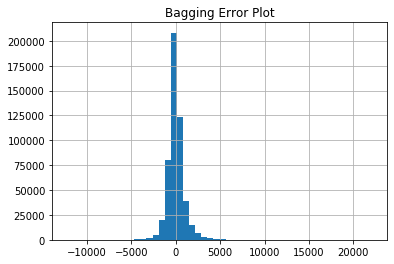

<Figure size 288x288 with 0 Axes>

In [80]:
#Checking Error Distribution :
(train_y-pred_bg_train).hist(bins=50)
plt.title("Bagging Error Plot")
plt.figure(figsize=(4,4))

In [81]:
#Saving model
import pickle
pickle.dump(bg,open('bg_model','wb'))

### Random Forest :

In [82]:
#Building Random Forest model with different Tuning parameters
param_rf = {'n_estimators': [100,150,200],'max_depth':[5,6,7]}
rf = GridSearchCV(estimator=ensemble.RandomForestRegressor(), param_grid=param_rf, cv=3,verbose=True, n_jobs=-1)
rf= rf.fit(train_x,train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 14.8min finished


In [83]:
#Checking Accuracy for train and Test data
print(rf.score(train_x,train_y))
print(rf.score(test_x,test_y))

0.6919874533498098
0.689926057907711


In [85]:
#Predicting values for train and test 
pred_rf_train = rf.predict(train_x)
pred_rf_test = rf.predict(test_x)

In [86]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_rf_train))
print(metrics.mean_squared_error(test_y,pred_rf_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_rf_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_rf_test)))

Mean Square Error :

2979750.133288183
2970209.668094234

Root Mean Square Error :

1726.1952766961747
1723.4296237718074


<Figure size 288x288 with 0 Axes>

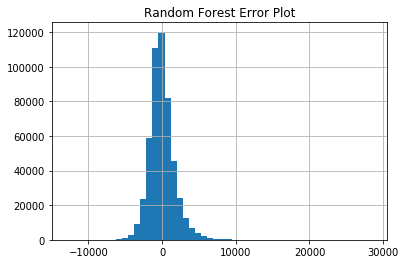

<Figure size 288x288 with 0 Axes>

In [87]:
#Checking Error Distribution :
(train_y-pred_rf_train).hist(bins=50)
plt.title("Random Forest Error Plot")
plt.figure(figsize=(4,4))

In [88]:
#Saving model
import pickle
pickle.dump(rf,open('rf_model','wb'))

### AdaBoost :

In [89]:
#Building AdaBoost Model with different tuning parameters
param_ada = {'n_estimators': [100,120,150,200],'learning_rate': [0.01]}
ad = GridSearchCV(estimator=ensemble.AdaBoostRegressor(), param_grid=param_ada, cv=3,verbose=True, n_jobs=-1)
ad = ad.fit(train_x,train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  7.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.5min finished


In [90]:
#Checking Accuracy for train and Test data
print(ad.score(train_x,train_y))
print(ad.score(test_x,test_y))

0.5382557052060012
0.5391056820460067


In [91]:
#Predicting values for train and test data
pred_ad_train = ad.predict(train_x)
pred_ad_test = ad.predict(test_x)

In [92]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_ad_train))
print(metrics.mean_squared_error(test_y,pred_ad_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_ad_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_ad_test)))

Mean Square Error :

4466969.410567765
4414923.582160283

Root Mean Square Error :

2113.5206198586675
2101.1719544483462


<Figure size 288x288 with 0 Axes>

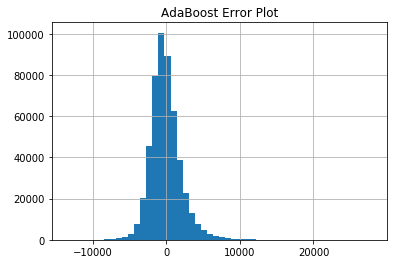

<Figure size 288x288 with 0 Axes>

In [93]:
#Checking Error Distribution :
(train_y-pred_ad_train).hist(bins=50)
plt.title("AdaBoost Error Plot")
plt.figure(figsize=(4,4))

In [94]:
#Saving model
import pickle
pickle.dump(ad,open('ad_model','wb'))

### Gradient Boost :

In [95]:
#Building Model with different tuning parameters.
param_gb = {'n_estimators': [100,150,200],'max_depth':[5,6],'learning_rate': [0.01]}
gb = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(), param_grid=param_gb, cv=3,verbose=True, n_jobs=-1)
gb = gb.fit(train_x,train_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 27.8min finished


In [96]:
#Checking Accuracy for train and Test data
print(gb.score(train_x,train_y))
print(gb.score(test_x,test_y))

0.7039914930871358
0.7035297108744891


In [97]:
#Predicting values for train and test 
pred_gb_train = gb.predict(train_x)
pred_gb_test = gb.predict(test_x)

In [98]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_gb_train))
print(metrics.mean_squared_error(test_y, pred_gb_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_gb_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_gb_test)))

Mean Square Error :

2863621.620354855
2839899.777199575

Root Mean Square Error :

1692.2238682735967
1685.2002187276073


<Figure size 288x288 with 0 Axes>

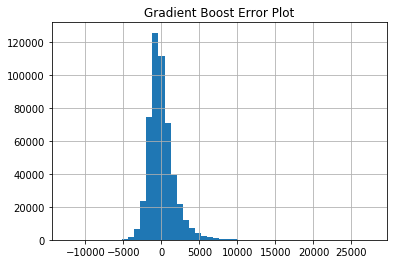

<Figure size 288x288 with 0 Axes>

In [99]:
#Checking Error Distribution :
(train_y-pred_gb_train).hist(bins=50)
plt.title("Gradient Boost Error Plot")
plt.figure(figsize=(4,4))

In [100]:
#Saving model
import pickle
pickle.dump(gb,open('gb_model','wb'))

### XGBoost :

In [109]:
#Building Model with different tuning parameters.
param_xg = {'n_estimators': [250,300,400],'max_depth':[8,10]}
xg = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param_xg, cv=3,verbose=True, n_jobs=-1)
xg = xg.fit(train_x,train_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 33.1min finished
C:\Users\Administrator\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:21:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [110]:
#Checking Accuracy for train and Test data
print(xg.score(train_x,train_y))
print(xg.score(test_x,test_y))

0.8913482331424294
0.8729059123471159


In [111]:
#Predicting values for train and test
pred_xg_train = xg.predict(train_x)
pred_xg_test = xg.predict(test_x)

In [112]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_xg_train))
print(metrics.mean_squared_error(test_y,pred_xg_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_xg_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_xg_test)))

Mean Square Error :

1051110.1586505547
1217438.9287825297

Root Mean Square Error :

1025.2366354410842
1103.3761501784102


<Figure size 288x288 with 0 Axes>

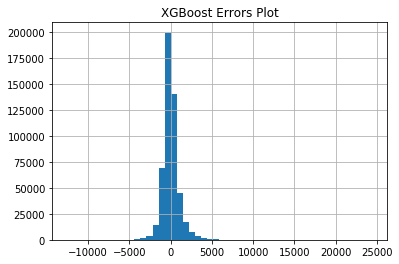

<Figure size 288x288 with 0 Axes>

In [113]:
#Checking Error Distribution :
(train_y-pred_xg_train).hist(bins=50)
plt.title("XGBoost Errors Plot")
plt.figure(figsize=(4,4))

In [114]:
#Saving model
import pickle
pickle.dump(xg,open('xg_model','wb'))

### KNN :

In [115]:
param_knn = [{'n_neighbors': [20,25,30],'leaf_size':[50,100,150]}]
kn = GridSearchCV(estimator=neighbors.KNeighborsRegressor(), param_grid=param_knn, cv=3,verbose=True, n_jobs=-1)
kn = kn.fit(train_x,train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.9min finished


In [116]:
#Checking Accuracy for train and Test data
print(kn.score(train_x,train_y))
print(kn.score(test_x,test_y))

0.8597914482292804
0.8464790836872588


In [117]:
#Predicting values for train and test
pred_kn_train = kn.predict(train_x)
pred_kn_test = kn.predict(test_x)

In [118]:
#Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_kn_train))
print(metrics.mean_squared_error(test_y, pred_kn_test))
#Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_kn_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_kn_test)))

Mean Square Error :

1356394.2617617615
1470582.4901309228

Root Mean Square Error :

1164.643405408609
1212.6757563878825


<Figure size 288x288 with 0 Axes>

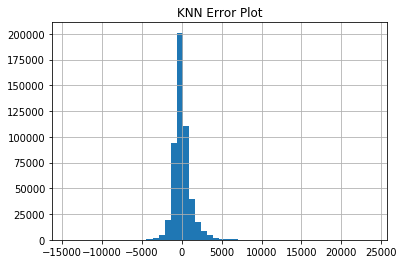

<Figure size 288x288 with 0 Axes>

In [119]:
#Checking Error Distribution :
(train_y-pred_kn_train).hist(bins=50)
plt.title("KNN Error Plot")
plt.figure(figsize=(4,4))

In [120]:
#Saving model
import pickle
pickle.dump(kn,open('kn_model','wb'))

### Predicting Values for Testing Data

In [129]:
#Creating empty data frmae for storing results
Results = pd.DataFrame()
#Storing results
Results['Store'] = TEST_1.Store
Results['LinearRegression_Predictions'] = lr.predict(TEST_x)
Results['LassoRegression_Predictions'] = ls.predict(TEST_x)
Results['RidgeRegression_Predictions'] = rg.predict(TEST_x)
Results['DecisionTrees_Predictions'] = dt.predict(TEST_x)
Results['Bagging_Predictions'] = bg.predict(TEST_x)
Results['RandomForest_Predictions'] = rf.predict(TEST_x)
Results['AdaBoost_Predictions'] = ad.predict(TEST_x)
Results['GradientBoost_Predictions'] = gb.predict(TEST_x)
Results['XGBoost_Predictions'] = xg.predict(TEST_x)
Results['KNN_Predictions'] = kn.predict(TEST_x)

In [130]:
#Exporting results into Excel.
Results.to_excel("Result.xlsx")